In [1]:
import json
import itertools
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.common import flatten  
from random import sample
from collections import Counter
from functools import reduce
from matplotlib.lines import Line2D


################  DATA IMPORT, CLEANING AND MUNGING  ####################
################  DATA IMPORT, CLEANING AND MUNGING  ####################
################  DATA IMPORT, CLEANING AND MUNGING  ####################
# Multiple string replace function #####################

def multReplaceStr (stri):
    lis_=[]
    in_=['\n', 'Type', 'Method', 'Location']
    out_=[' ', '', '::', '::']
    for ele in stri:
        ele1 = ele.replace(in_[0], out_[0])
        ele2 = ele1.replace(in_[1], out_[1])
        ele3 = ele2.replace(in_[2], out_[2])
        ele4 = ele3.replace(in_[3], out_[3])
        ele5 = ele4.split('::')
        lis_.append(ele5)    
    return lis_   
####################################
## read in Selenium scrape data in json format  

with open('groupOverview_l.json') as f:
    data = json.loads("[" + 
        f.read().replace("][", "],\n[") + 
    "]")
    #print(data[0][2])
    group = pd.Series(flatten([data[i][0] for i in range(len(data))]))
    OverviewText = pd.Series(flatten([data[i][1] for i in range(len(data))]))
    BGA = pd.Series([data[i][2] for i in range(len(data))])
    TypeNames_= []
    Method_ = []
    Location_ = []
    OverallScore_ = []
    for ind in range(len(data)):
        TML = multReplaceStr(data[ind][3])
        TypeNames_.append([x.strip(' ') for x in (TML[i][0] for i in range(len(TML)))])
        TypeNames = pd.Series(TypeNames_)
        Method_.append([x.strip(' ') for x in (TML[i][1] for i in range(len(TML)))])
        Method = pd.Series(Method_)
        Location_.append([x.strip(' ') for x in (TML[i][2] for i in range(len(TML)))])
        Location = pd.Series(Location_)
        OverallScore_.append([i.replace('Overall Score: ', '') for i in data[ind][4]])
        OverallScore = pd.Series(OverallScore_)
# len(list(flatten(BGA))) #1697
# len(list(flatten(TypeNames))) #2341
# len(list(flatten(Method))) #2341
# len(list(flatten(Location))) #2341
# len(list(flatten(OverallScore))) #1687


In [2]:
################  EDA FOR MEANS  ####################
################  EDA FOR MEANS  ####################
################  EDA FOR MEANS  ####################
## Calculate Mean of OverallScore for all groups
# remove blank strings and flatten into single list

OverallScore_c =[str for str in list(flatten(OverallScore)) if str != ''] 
# convert all strings to float and mean

np.mean([float(x) for x in OverallScore_c])
## 3.05157338902148 
## len(OverallScore_c)
## 1676

np.sum([float(x) for x in OverallScore_c]) #5114.437
# len(list(flatten(OverallScore)))
# 1687
## Calculate mean of OverallScore by groups

lis_=[]
NestRedo=[]

for li in OverallScore:
    byNest = [str for str in list(flatten(li)) if str != ''] 
    NestRedo.append(byNest)
    lis_.append(np.mean([float(x) for x in byNest]))
    meanByGroup = pd.Series(lis_)

meanByGroup

np.mean(meanByGroup)
## 3.2972108307693793
## len(list(flatten(NestRedo))) # 1676


3.2972108307693793

In [3]:
best_l=[]
good_l=[]
avoid_l=[]

for x in BGA:
    best_l.append(x.count('BEST CHOICE'))
    best = pd.Series(best_l)
    good_l.append(x.count('GOOD ALTERNATIVE'))
    good = pd.Series(good_l)
    avoid_l.append(x.count('AVOID'))
    avoid = pd.Series(avoid_l)

numScored = pd.Series([len(x) for x in BGA ])
numTotal = pd.Series([len(x) for x in Location])
overText = pd.Series([x.strip() for x in OverviewText])

simple_df = pd.concat([group, best, good, avoid, meanByGroup, numScored, numTotal-numScored, numTotal, overText], axis=1, keys=['group', 'best', 'good', 'avoid', 'meanGroupScore', 'numScored', 'numUnScored', 'numTotal', 'overviewText'])
# save to csv

simple_df.to_csv('simple_df.csv')


In [4]:
##  SECOND DATAFRAME WITH INDIVIDUAL SCORES, TYPENAMES, METHOD, LOCATION
# expected number of rows for detailed dataframe
# len(list(flatten(BGA))) #1697
# len(list(flatten(TypeNames))) #2341
# len(list(flatten(Method))) #2341
# len(list(flatten(Location))) #2341
# len(list(flatten(OverallScore))) #1687

detail_df=[]

for i in range(len(group)):
    df_ = pd.concat([pd.Series(np.repeat(group[i], [len(Location[i])])), pd.Series(BGA[i]), pd.Series(TypeNames[i]), pd.Series(Method[i]), pd.Series(Location[i]), pd.Series(OverallScore[i])], axis=1, keys=['group', 'recommend', 'typeNames', 'method', 'location', 'overallScore' ] )
    detail_df.append(df_)

detail_df = pd.concat(detail_df, axis=0)
detail_df['overallScore']= detail_df['overallScore'].fillna(10)

detail_df['overallScore']= pd.to_numeric(detail_df['overallScore'], errors='coerce')
# fix several entries in overallScore column that were incorrectly assigned to 10 when they should be NaN. In Snapper and Shrimp groups

detail_df.loc[((detail_df['recommend'] == 'AVOID') & (detail_df['overallScore'] == 10)), 'overallScore'] = 'NaN'
# save to csv

detail_df.to_csv('detail_df.csv')


In [6]:
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
################  EDA FOR FREQUENCY DISTRIBUTIONS  ####################
# frequency distributions 

Counter(detail_df['recommend'])
# Counter({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, nan: 644, 'AVOID': 623})
# Counter(detail_df['method'])
# Counter(detail_df['location'])


Counter({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, nan: 644, 'AVOID': 623})

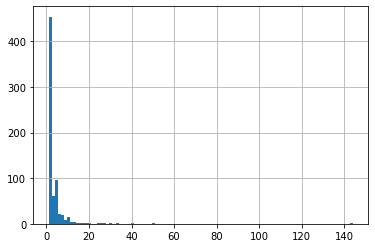

In [7]:
detail_df['location'].value_counts().hist(bins=100)


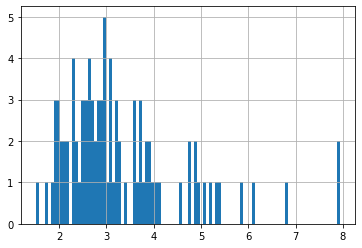

In [10]:
simple_df['meanGroupScore'].hist(bins=100)


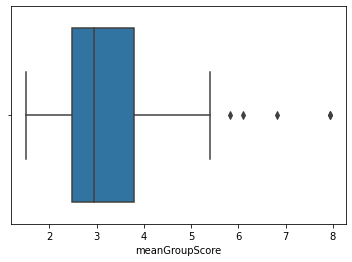

In [15]:
sns.boxplot(simple_df['meanGroupScore'])


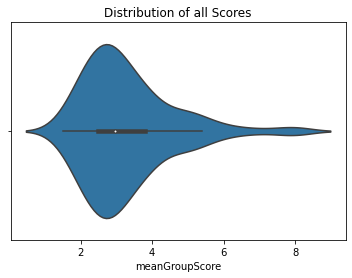

In [16]:
plt.title('Distribution of all Scores')
sns.violinplot(simple_df['meanGroupScore'])


In [24]:
detail_df.loc[((detail_df['recommend'] == 'AVOID') & (detail_df['overallScore'] == 10)), 'overallScore'] = 'NaN'


In [28]:
detail_df.groupby('method').agg({'overallScore':'mean'})


overallScore
method                                              
All production methods                     10.000000
Barriers, fences, weirs, corrals, etc.      3.781952
Beach Seines                               10.000000
Beach seines                                8.056381
Beam trawls                                 4.826333
...                                              ...
Trolling lines                              4.315063
Trotline                                    3.177333
Unassociated purse seine (non-FAD)          2.524220
Vertical Lines                              1.790000
Vertical lines                              2.022000

[109 rows x 1 columns]

In [29]:
detail_df.groupby('location').agg({'overallScore':'mean'})


overallScore
location                                                        
Antarctica - Southern Ocean                             3.000000
Aquaculture Stewardship Council (Worldwide)            10.000000
Aquaculture Stewardship Council Certified Arcti...     10.000000
Aquaculture Stewardship Council Certified Bival...     10.000000
Aquaculture Stewardship Council Certified Farms...     10.000000
...                                                          ...
West Atlantic Ocean (Atlantic stock)                    2.341714
West Atlantic Ocean (Western Atlantic stock)            2.430600
Western Central Pacific Ocean                           1.749000
Western and Central Pacific Ocean                       2.659364
Worldwide                                               7.101250

[699 rows x 1 columns]

In [30]:
detail_df.groupby('recommend').agg({'overallScore':'mean'})


overallScore
recommend                     
AVOID                 1.991246
BEST CHOICE           5.080902
GOOD ALTERNATIVE      3.190265

In [32]:
#### IMPORTANT: Note that assigning scores of 10 for ECO-certified sources skews data. Will need to change this for further analysis


Text(-2.2, 2.2, '623 Sources')

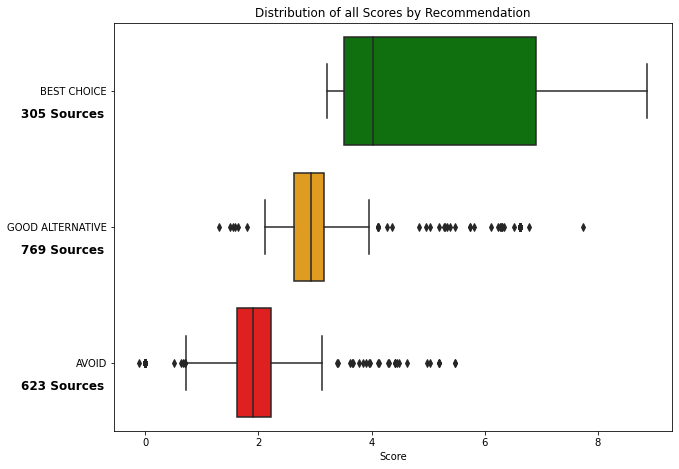

In [33]:
## Distribution of recommendations box plot

plt.figure(figsize=(10, 7.5))
plt.title('Distribution of all Scores by Recommendation')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}
p1 = sns.boxplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal)
plt.xlabel('Score')
plt.ylabel('')
p1.text(-2.2, 0+0.2, "305 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')
p1.text(-2.2, 1+0.2, "769 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')
p1.text(-2.2, 2+0.2, "623 Sources", horizontalalignment='left', size='large', color='black', weight='semibold')


Text(-3.1, 2.2, '623 Sources')

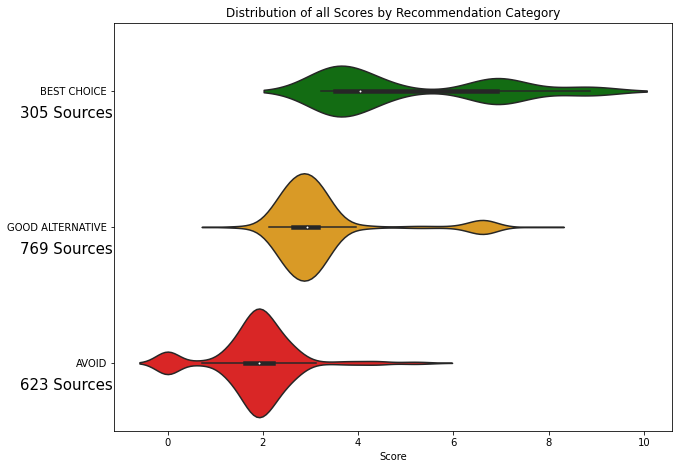

In [34]:
## Distribution of recommendations violin plot, without or with swarm overlay

plt.figure(figsize=(10, 7.5))
plt.title('Distribution of all Scores by Recommendation Category')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}

p1 = sns.violinplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal, saturation =0.7)
#p1 = sns.swarmplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, color='gray', edgecolor='black')

plt.xlabel('Score')
plt.ylabel('')
p1.text(-3.1, 0+0.2, "305 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 1+0.2, "769 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 2+0.2, "623 Sources", horizontalalignment='left', size=15, color='black')


Text(-3.1, 2.2, '623 Sources')

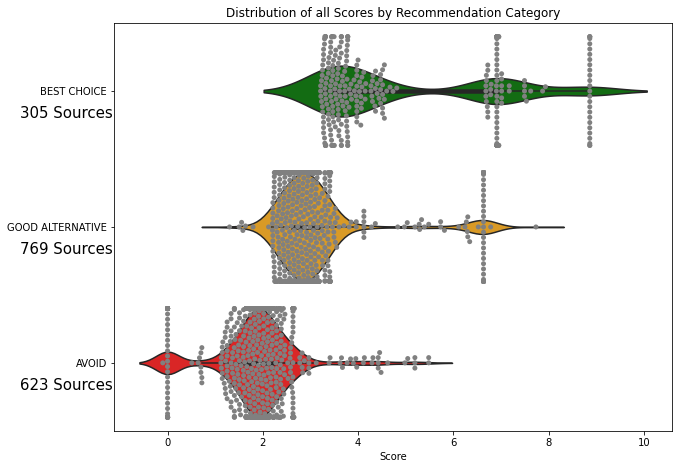

In [35]:
## Distribution of recommendations violin plot, without or with swarm overlay

plt.figure(figsize=(10, 7.5))
plt.title('Distribution of all Scores by Recommendation Category')
my_pal = {"BEST CHOICE": "g", "GOOD ALTERNATIVE": "orange", "AVOID":"r"}
p1 = sns.violinplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, palette=my_pal, saturation =0.7)
p1 = sns.swarmplot(y= detail_df.loc[(detail_df['overallScore'] != 10), 'recommend'],   x=detail_df.loc[(detail_df['overallScore'] != 10), 'overallScore'], data=detail_df, color='gray', edgecolor='black')
plt.xlabel('Score')
plt.ylabel('')
p1.text(-3.1, 0+0.2, "305 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 1+0.2, "769 Sources", horizontalalignment='left', size=15, color='black')
p1.text(-3.1, 2+0.2, "623 Sources", horizontalalignment='left', size=15, color='black')


In [36]:
# based on distribution, want to know what sources have scores higher than 6:

scorehigher6_df = detail_df.loc[((detail_df['overallScore'] > 6) & (detail_df['overallScore'] != 10 ))]
# 172 sources
# save csv table

scorehigher6_df.to_csv('scorehigher6_df.csv')
#summary of sources with score higher than 6

scorehigher6count_df = scorehigher6_df.groupby('group').agg({'group': 'count'})

scorehigher6count_df.columns = ["Num_Sources"]
# save csv table

scorehigher6count_df.to_csv('scorehigher6count_df.csv')


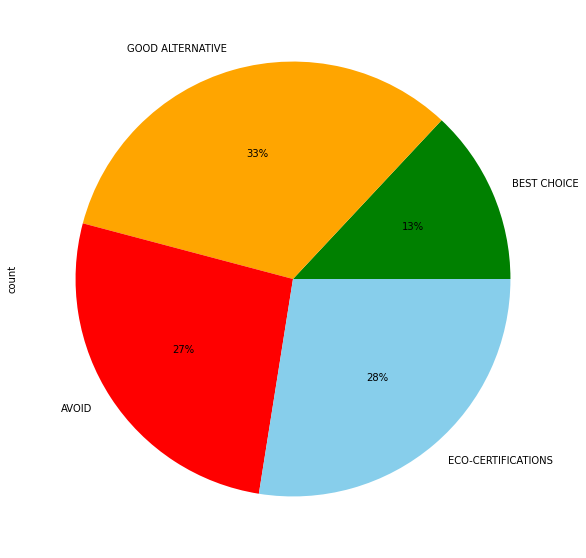

In [37]:
## Recommendations pie chart
# Counter({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, nan: 644, 'AVOID': 623})

recs= pd.DataFrame([pd.Series({'BEST CHOICE': 305, 'GOOD ALTERNATIVE': 769, 'AVOID': 623, 'ECO-CERTIFICATIONS': 644})]).T
recs.columns= ['count']
recs.plot.pie(y= 'count', figsize=(10,10), autopct='%1.0f%%', legend=False, colors = ['green', 'orange', 'red', 'skyblue'])
plt.show()


([<matplotlib.patches.Wedge at 0x11e298340>,
 [Text(8.799492862917393, 0.09447409944451664, 'Abalone'),
  Text(8.78535241727824, 0.5075262596392336, 'Amberjack'),
  Text(8.733015628824186, 1.0837149194841402, 'Anchovy'),
  Text(8.682321017955347, 1.4343297184297714, 'Arctic Char'),
  Text(8.664364506595804, 1.539086643708817, 'Barnacle'),
  Text(8.640701527925273, 1.6668164581950418, 'Bass'),
  Text(8.610309099098222, 1.817299429919671, 'Bluefish'),
  Text(8.600429921830054, 1.8634927313220955, 'Bowfin'),
  Text(8.571985245259198, 1.9902434411545324, 'Bream'),
  Text(8.535961105282915, 2.139478443242019, 'Brill'),
  Text(8.509498769550644, 2.2424162617623162, 'Butterfish'),
  Text(8.484934480994944, 2.33364240045965, 'Cabezon'),
  Text(8.452854206279989, 2.4472956027776274, 'Capelin'),
  Text(8.128444165100243, 3.371705125726124, 'Carp'),
  Text(7.633785010082798, 4.377822109203981, 'Catfish'),
  Text(7.303372596705176, 4.909251339430067, 'Clams'),
  Text(7.029453214302518, 5.294033198

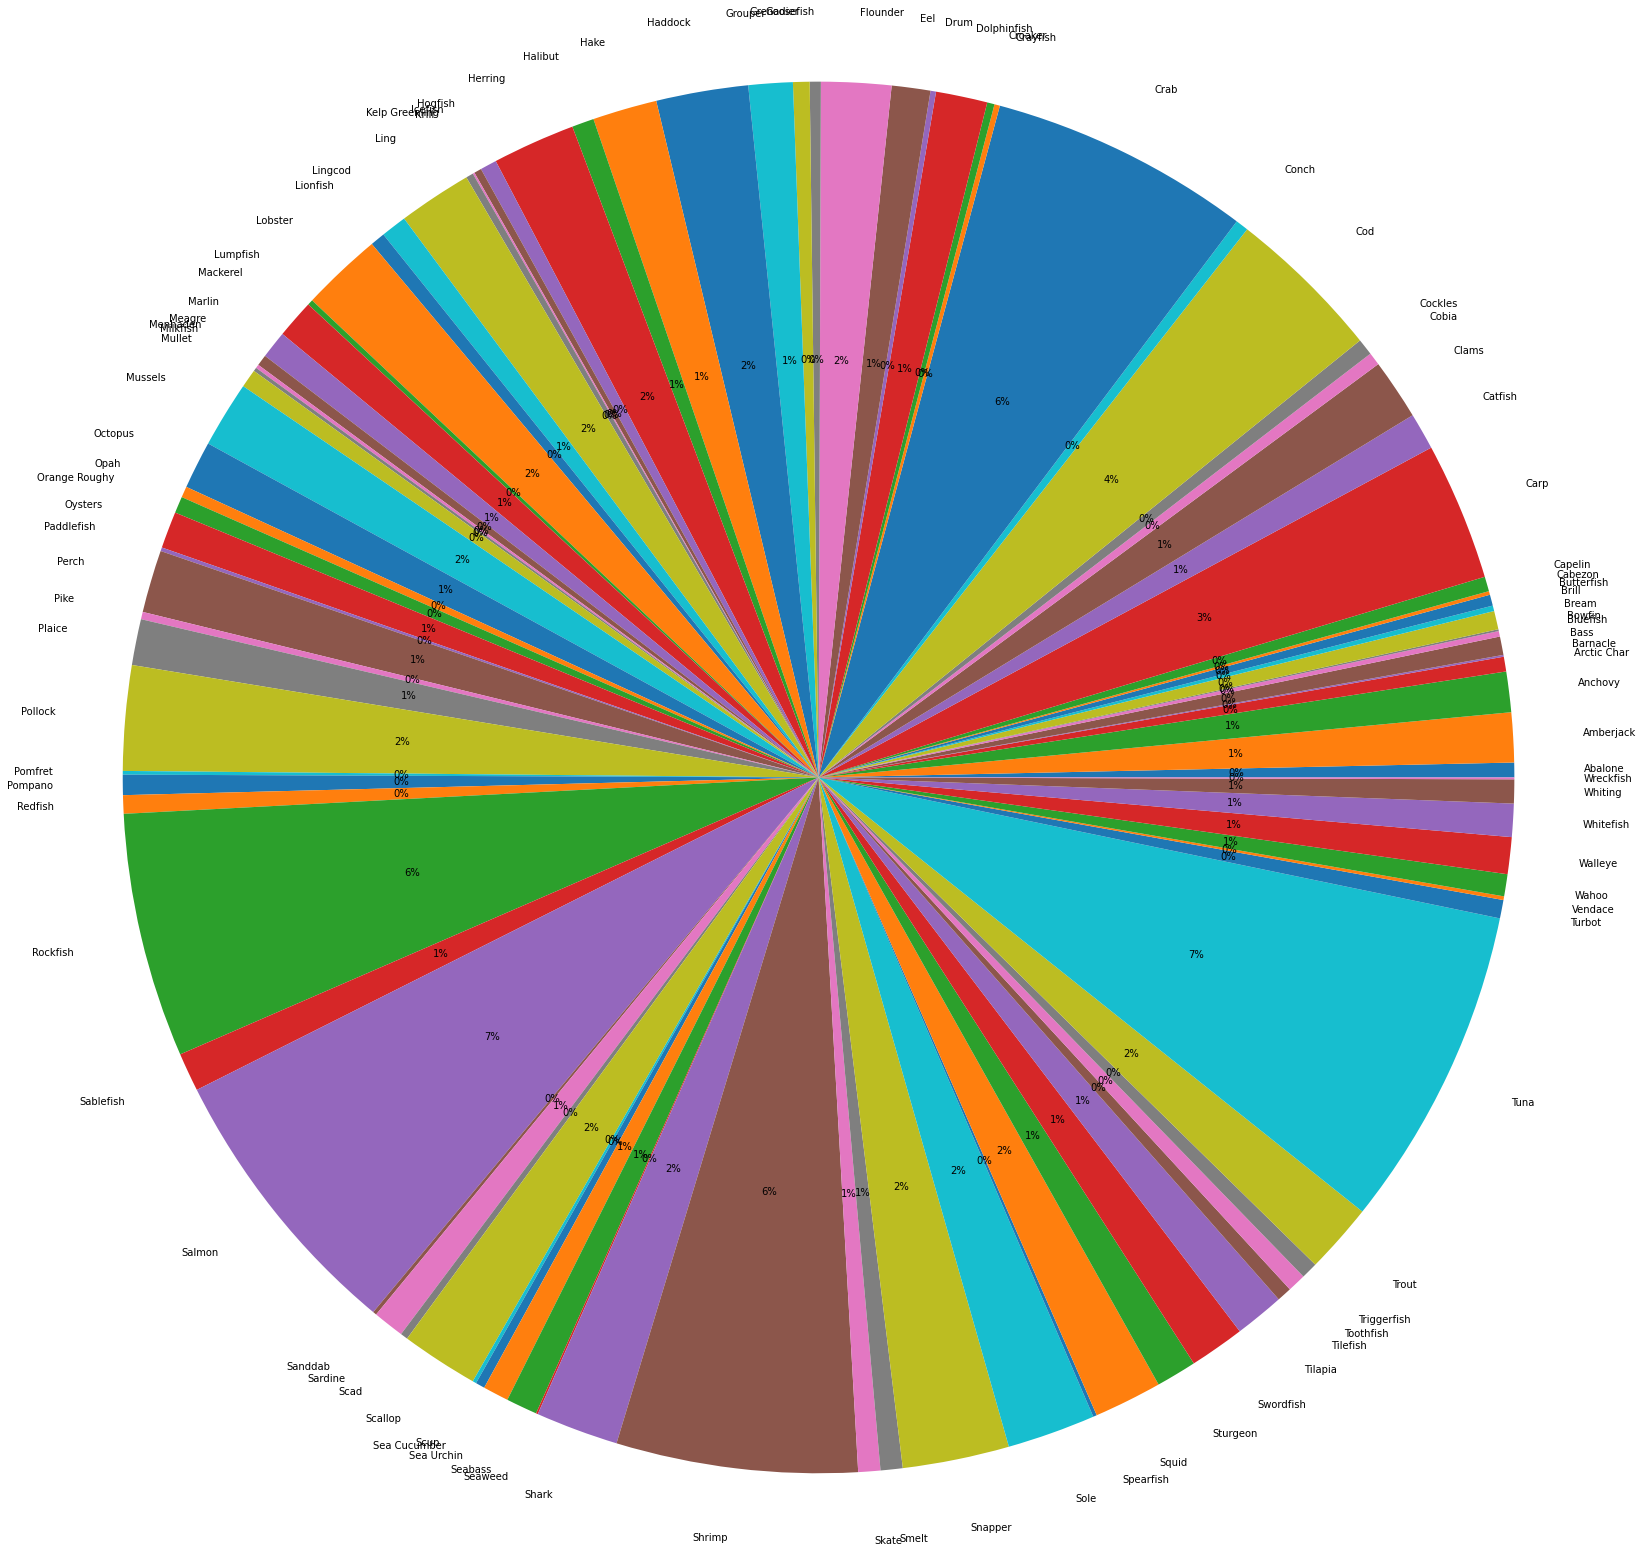

In [38]:
## Groups pie chart
# matplotlib plotting, pandas plotting used in pie plot above didnt work as didnt allow groups labeling

plt.pie(simple_df['numTotal'], labels=simple_df['group'], autopct='%1.0f%%', radius=8)


In [43]:
#########  SET FONT SIZES FOR GRAPHS  #########

size=15

params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size*1.0,
          'axes.titlesize': size*2,
          'axes.labelsize': size*1.1,
          'xtick.labelsize': size*1.05,
          'ytick.labelsize': size*1.0,
          'axes.titlepad': 25,
          'figure.titlesize': size*2,
          'legend.fontsize': size}

plt.rcParams.update(params)


Text(0, 0.5, '')

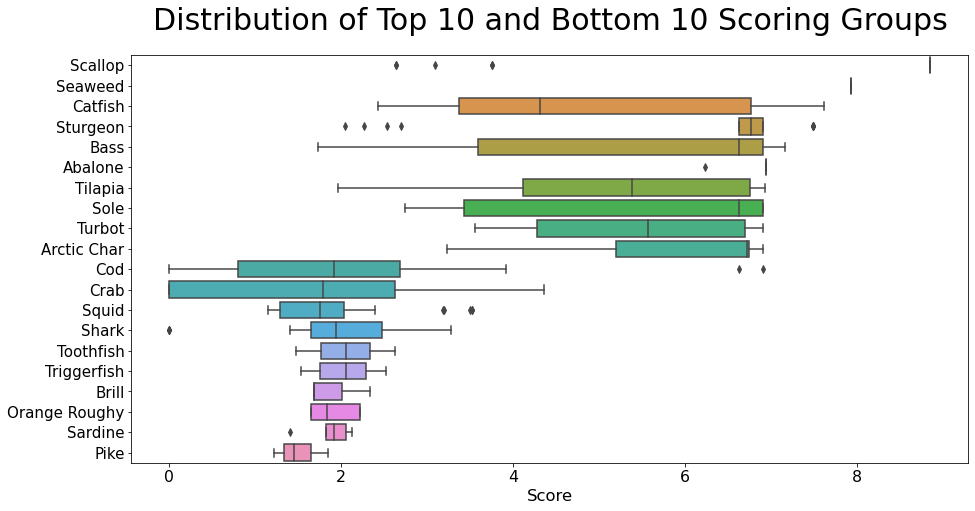

In [44]:
# Top/Bottom 10 groups boxplot
# make dataframes with high or low groups 

low10_groups = simple_df.loc[(simple_df['meanGroupScore'] <2.06 ), 'group']
high10_groups = simple_df.loc[(simple_df['meanGroupScore'] >4.9 ), 'group']
low10_groups.tolist()
low10_df=[]

for grp in low10_groups.tolist():
    df_ = detail_df.loc[(detail_df['group'] == grp ), ('group', 'recommend', 'typeNames', 'method', 'location', 'overallScore')]
    low10_df.append(df_)

low10_df = pd.concat(low10_df, axis=0)
high10_groups.tolist()
high10_df=[]

for grp in high10_groups.tolist():
    df_ = detail_df.loc[(detail_df['group'] == grp ), ('group', 'recommend', 'typeNames', 'method', 'location', 'overallScore')]
    high10_df.append(df_)

high10_df = pd.concat(high10_df, axis=0)
# combine both high and low dataframes together to simplify plotting

highlow_df= pd.concat([high10_df, low10_df], axis=0).sort_values('overallScore', ascending = False)
plt.figure(figsize=(15, 7.5))
plt.title('Distribution of Top 10 and Bottom 10 Scoring Groups')
p1 = sns.boxplot(y= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'group'],   x= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'overallScore'], data=highlow_df)
plt.xlabel('Score')
plt.ylabel('')


Text(0, 0.5, '')

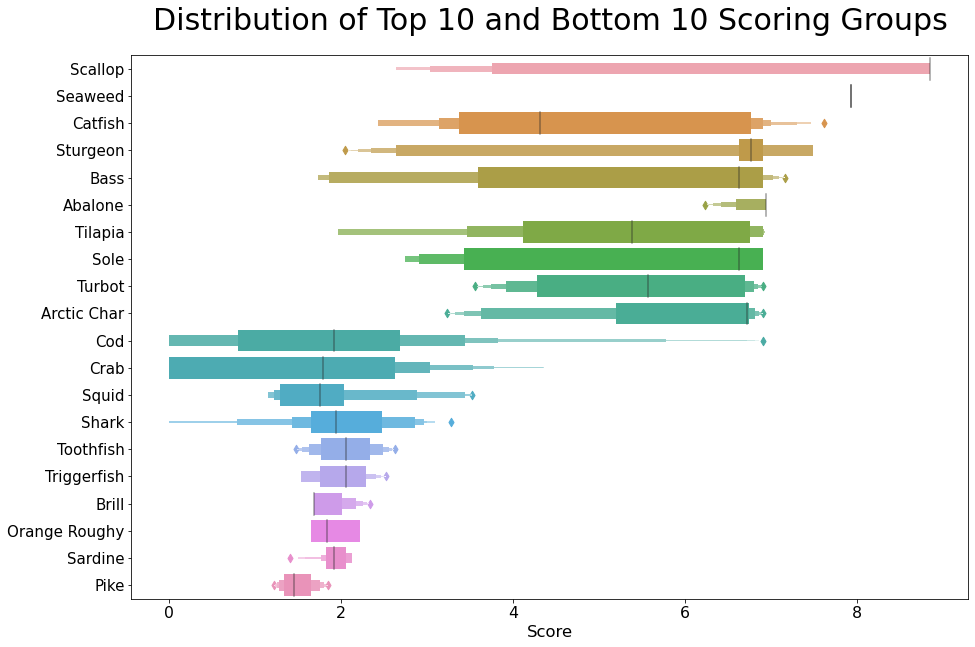

In [45]:
# boxen plot version

plt.figure(figsize=(15, 10))
plt.title('Distribution of Top 10 and Bottom 10 Scoring Groups')
p1 = sns.boxenplot(y= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'group'],   x= highlow_df.loc[(highlow_df['overallScore'] != 10) ,'overallScore'], data=highlow_df)
plt.xlabel('Score')
plt.ylabel('')


Text(0, 0.5, '')

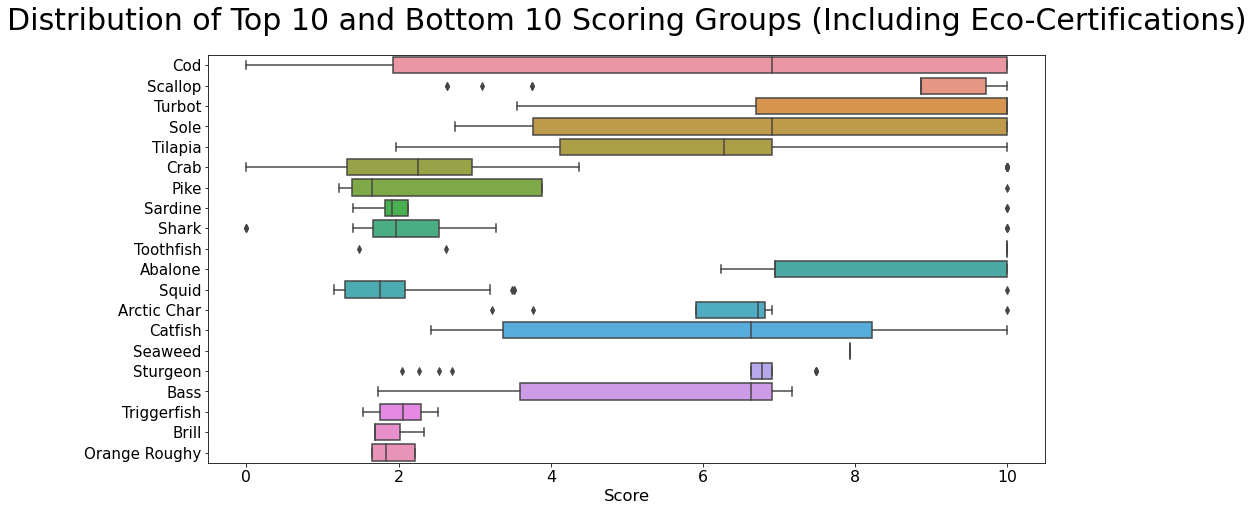

In [46]:
# same plot as above but including the Eco certifications (score = 10)

plt.figure(figsize=(15, 7.5))
plt.title('Distribution of Top 10 and Bottom 10 Scoring Groups (Including Eco-Certifications)')
p1 = sns.boxplot(y= highlow_df['group'],   x= highlow_df['overallScore'], data=highlow_df)
plt.xlabel('Score')
plt.ylabel('')


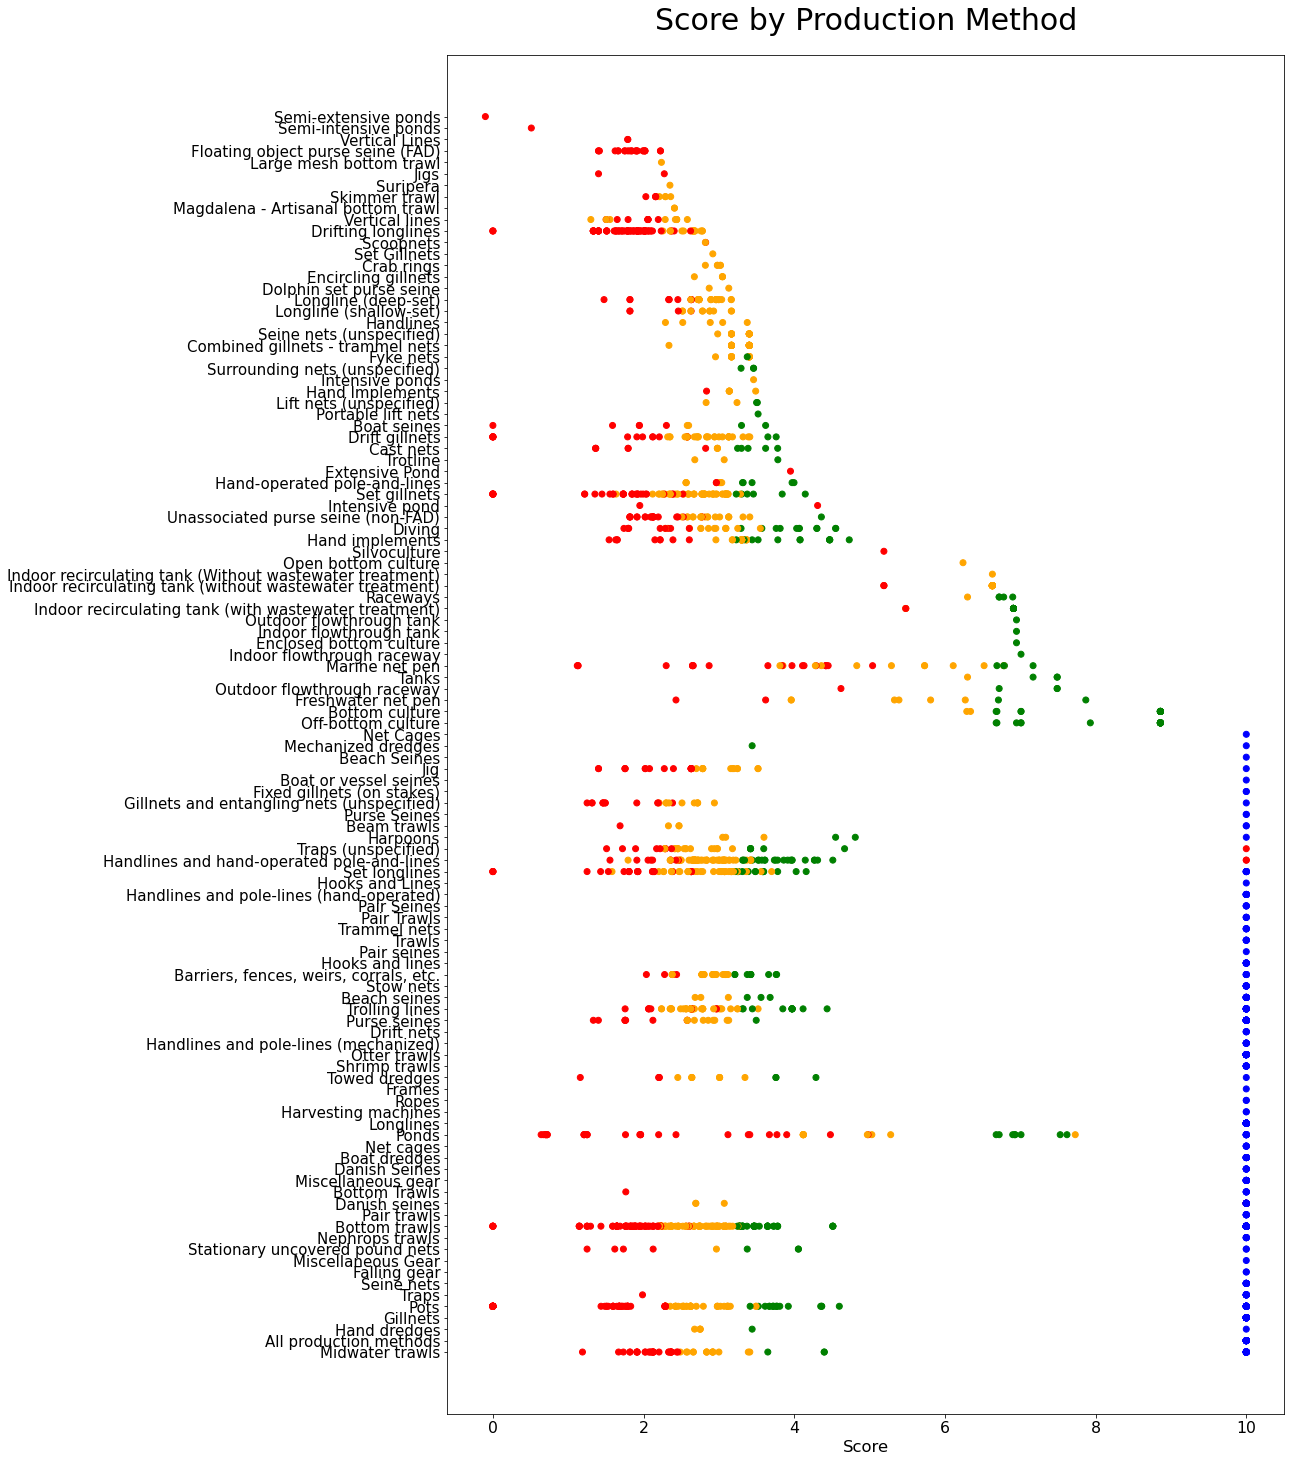

In [47]:
## Scores by Production Method

sortS_detail_df= detail_df.sort_values('overallScore', ascending = False)
# function to create list of colors according to recommend column

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l=='BEST CHOICE':
            cols.append('green')
        elif l=='AVOID':
            cols.append('red')
        elif l=='GOOD ALTERNATIVE':
            cols.append('orange')   
        else:
            cols.append('blue')
    return cols

cols = pltcolor(sortS_detail_df['recommend'])
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Score by Production Method')
plt.scatter(sortS_detail_df['overallScore'], sortS_detail_df['method'], c=cols)


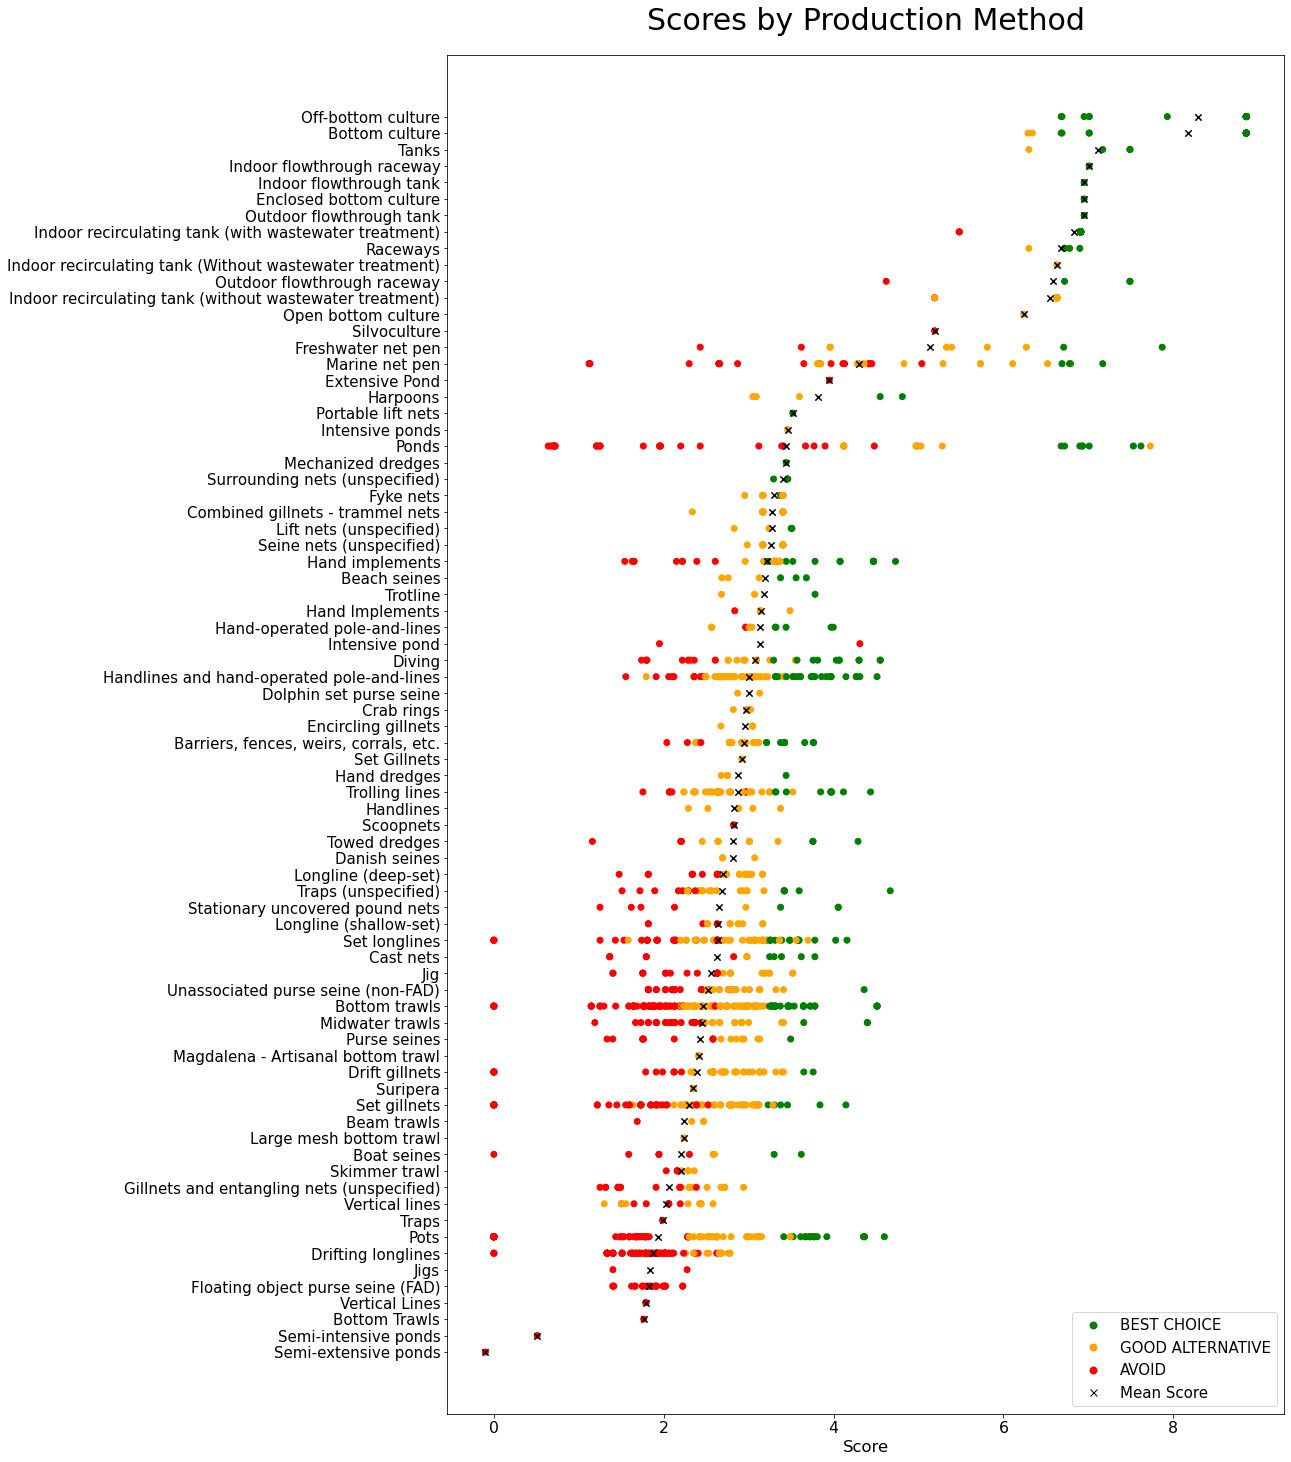

In [48]:
## Scores by Production method without Eco-cert.
# remove scores of 10 and reorder method column by mean overallScore for each grouped method:

sortS_detail_df= detail_df.loc[(detail_df['overallScore'] != 10)]

sortSmean_detail_df= sortS_detail_df.iloc[(sortS_detail_df.groupby('method')['overallScore'].transform('mean')).argsort()]
# get list of 76 methods ordered above by mean overallScore

grp=sortSmean_detail_df.groupby('method')
method_grp=[]

for key, values in grp:
    method_grp.append(key)
# create list of colors according to recommend column

cols = pltcolor(sortSmean_detail_df[ 'recommend'])
plt.figure(figsize=(15, 25))
plt.xlabel('Score')
plt.title('Scores by Production Method')
plt.scatter(sortSmean_detail_df['overallScore'], sortSmean_detail_df['method'], c=cols )
plt.scatter(sortSmean_detail_df.groupby('method').agg({'overallScore':'mean'}), method_grp, c='k', marker='x', label='Mean',s=40)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Mean Score', linewidth=0, markersize=7)]

plt.legend(handles= legend_elements, loc= 'lower right')


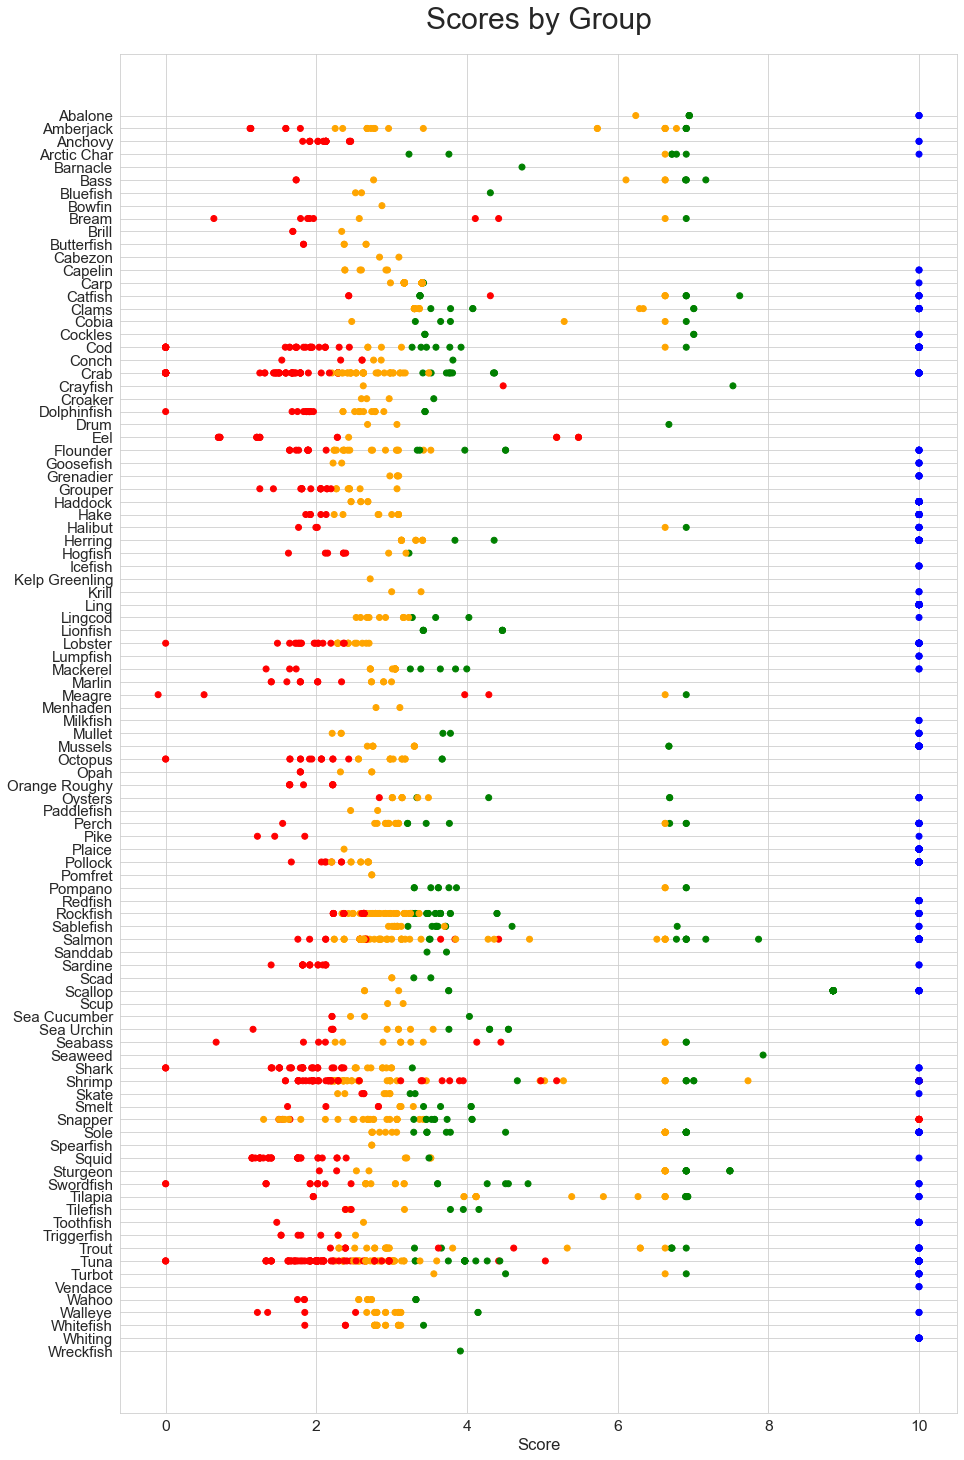

In [49]:
## Scores by Groups scatter strip plot

sort_detail_df= detail_df.sort_values('group', ascending = False)
# create list of colors according to recommend column

cols = pltcolor(sort_detail_df['recommend'])
sns.set_style("whitegrid")
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Scores by Group')
plt.scatter(sort_detail_df['overallScore'], sort_detail_df['group'], c=cols)


Text(0.5, 1.0, 'Source Recommendation Categories by Group')

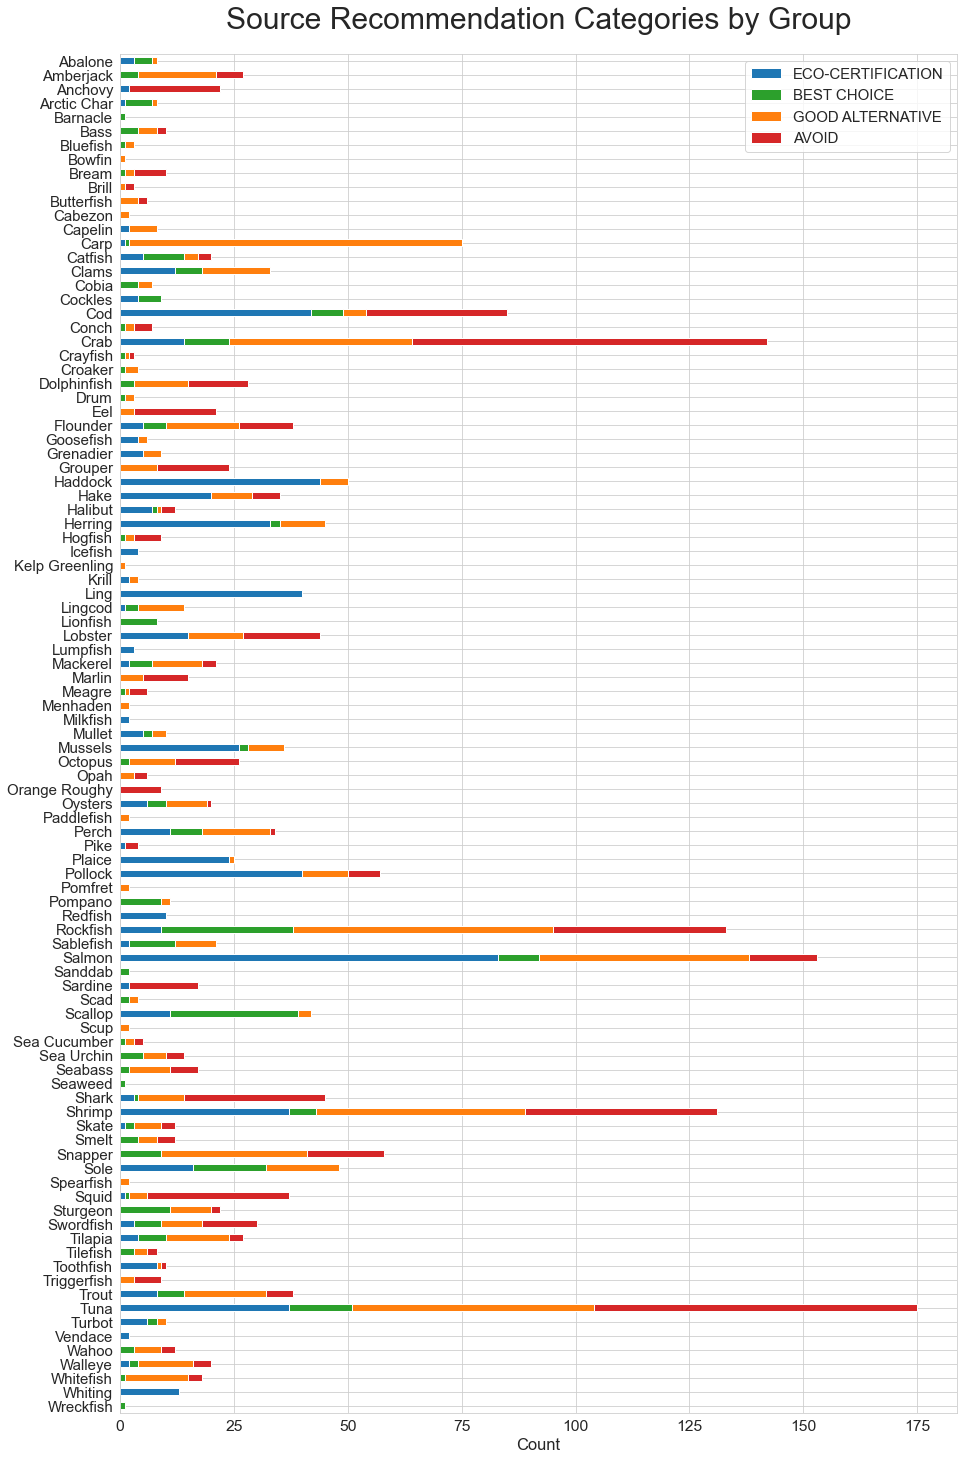

In [50]:
## Scores by groups with ECO-Cert. stacked bar plot:

columns2=['group','numUnScored','best', 'good', 'avoid' ]
simpleStaBar_df= simple_df[columns2].sort_values('group', ascending = False)
simpleStaBar_df.columns= ['group', 'ECO-CERTIFICATION', "BEST CHOICE", "GOOD ALTERNATIVE", "AVOID"]
simpleStaBar_df=simpleStaBar_df.set_index('group')
simpleStaBar_df.plot(kind='barh', stacked=True, figsize=(15, 25), color=['tab:blue','tab:green','tab:orange', 'tab:red'])
plt.xlabel('Count')
plt.ylabel('')
plt.title('Source Recommendation Categories by Group')


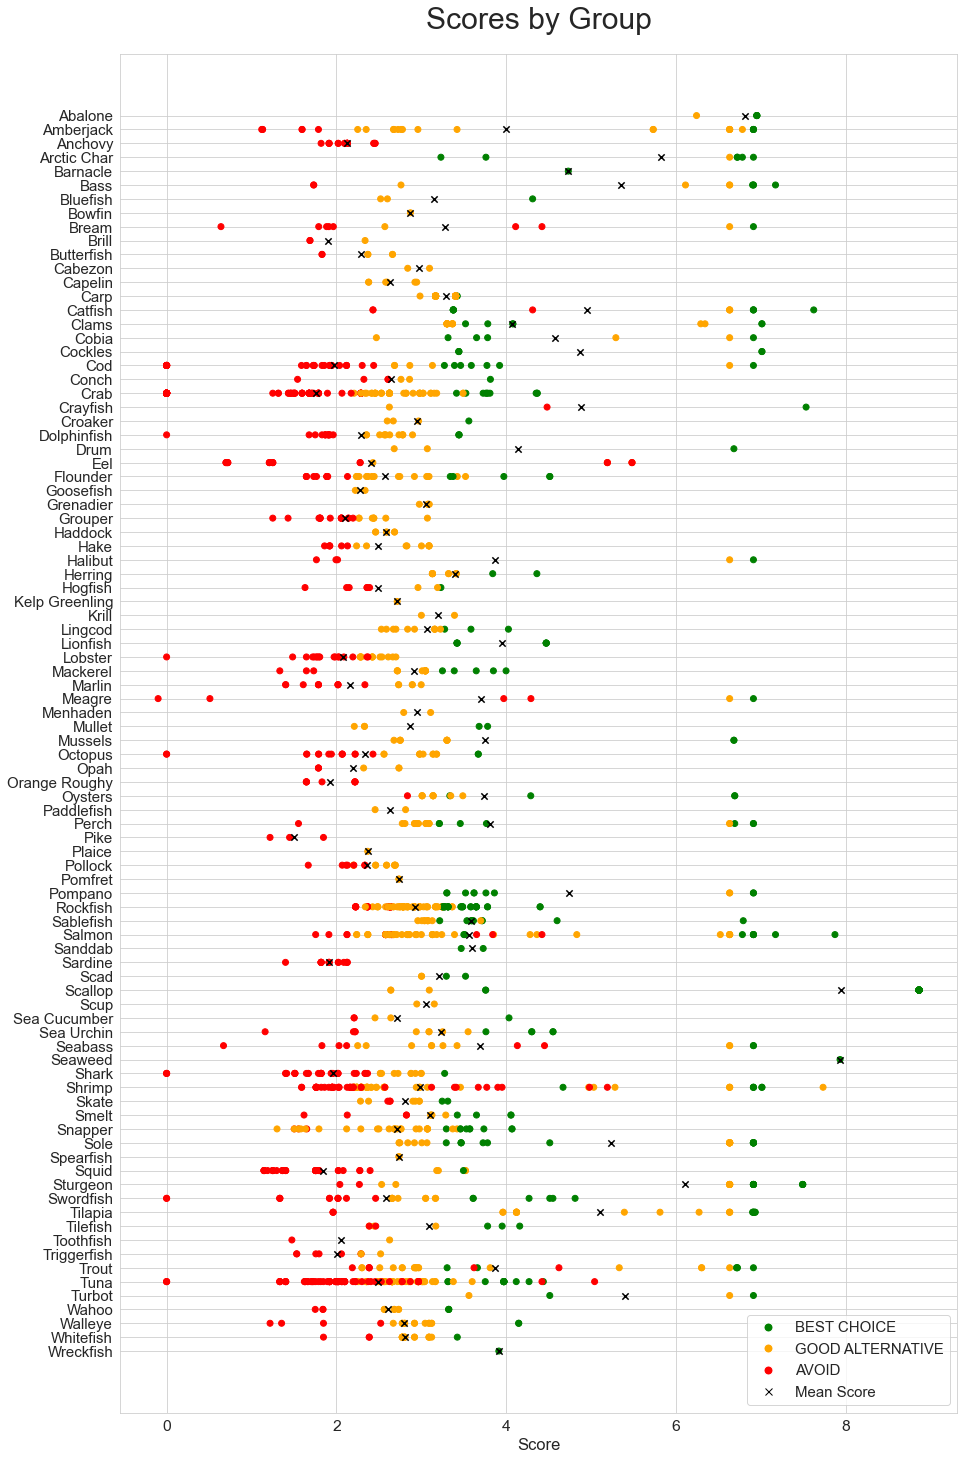

In [51]:
## Scores by groups without ECO-cert.

sortS_detail_df= sortS_detail_df.sort_values('group', ascending = False)
# create list of colors according to recommend column

cols = pltcolor(sortS_detail_df['recommend'] )
grp=sortS_detail_df.groupby('group')
group_grp=[]

for key, values in grp:
    group_grp.append(key)

sns.set_style("whitegrid")
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Scores by Group')
plt.scatter(sortS_detail_df['overallScore'], sortS_detail_df['group'], c=cols)
plt.scatter(sortS_detail_df.groupby('group').agg({'overallScore':'mean'}), group_grp, c='k', marker='x', label='Mean',s=40)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Mean Score', linewidth=0, markersize=7)]

plt.legend(handles= legend_elements, loc= 'lower right')


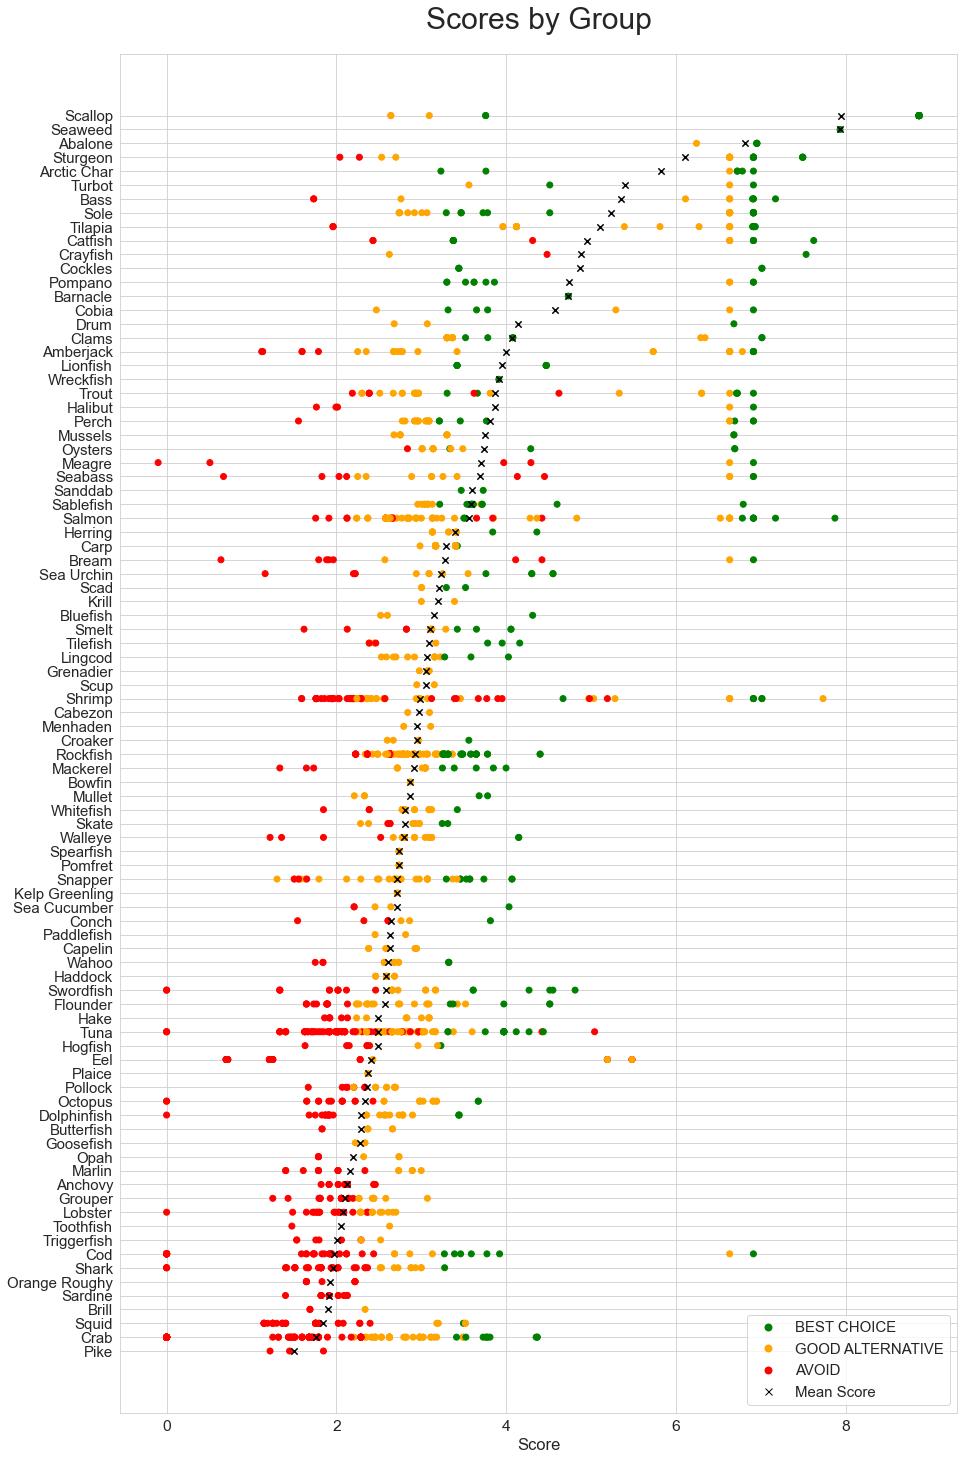

In [52]:
## Scores by groups without ECO cert., same plot as above but with groups sorted by mean score

sortGmean_detail_df= sortS_detail_df.iloc[(sortS_detail_df.groupby('group')['overallScore'].transform('mean')).argsort()]
# create list of colors according to recommend column

cols = pltcolor(sortGmean_detail_df['recommend'] )
# get list of 76 methods ordered above by mean overallScore

grp=sortGmean_detail_df.groupby('group')
group_grp=[]

for key, values in grp:
    group_grp.append(key)

sns.set_style("whitegrid")
plt.figure(figsize=(15, 25))

plt.xlabel('Score')
#plt.ylabel('Probability')

plt.title('Scores by Group')
plt.scatter(sortGmean_detail_df['overallScore'], sortGmean_detail_df['group'], c=cols)
plt.scatter(sortGmean_detail_df.groupby('group').agg({'overallScore':'mean'}), group_grp, c='k', marker='x', label='Mean',s=40)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='BEST CHOICE', markerfacecolor='g', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='GOOD ALTERNATIVE', markerfacecolor='orange', markersize=9),
                   Line2D([0], [0], marker='o', color='w', label='AVOID', markerfacecolor='r', markersize=9),
                   Line2D([0], [0], marker='x', color='k', label='Mean Score', linewidth=0, markersize=7)]

plt.legend(handles= legend_elements, loc= 'lower right')
